# **Estratificacion del dengue en el departamento del Cauca, Colombia**

En este proyecto, trabajaremos con los siguientes datasets

- `entomologico.csv` : Contiene registros de muestras de insectos recolectados en diferentes localidades del departamento del Cauca, en donde cada registro tiene informacion sobre el numero de individuos, genero, especie, fecha y lugar de recoleccion.

In [10]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('ggplot')

In [11]:
df = pd.read_csv('../data/entomologico.csv')


df['locality']

0      Casa ubicada en el barrio Puerto Nuevo de Patí...
1      Casa ubicada en el barrio Puerto Nuevo de Patí...
2      Casa ubicada en el barrio Puerto Nuevo de Patí...
3      Casa ubicada en el barrio Puerto Nuevo de Patí...
4      Casa ubicada en el barrio Puerto Nuevo de Patí...
                             ...                        
524     Casa ubicada en el barrio San Antonio de Miranda
525     Casa ubicada en el barrio San Antonio de Miranda
526     Casa ubicada en el barrio San Antonio de Miranda
527     Casa ubicada en el barrio San Antonio de Miranda
528     Casa ubicada en el barrio San Antonio de Miranda
Name: locality, Length: 529, dtype: object

## **Análisis de diversidad de especies**

###  **Cantidad de registros por especie**

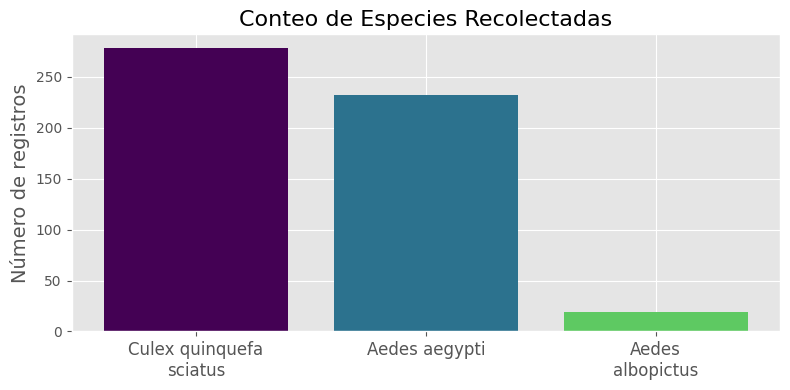


Distribución de especies:


,scientificName,Cantidad,Porcentaje
0,Culex quinquefasciatus,278,52.55
1,Aedes aegypti,232,43.86
2,Aedes albopictus,19,3.59


In [12]:
sc = df['scientificName'].value_counts()
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(sc.index, sc.values, color=plt.cm.viridis(np.linspace(0, 0.75, len(sc))))

ax.set_title('Conteo de Especies Recolectadas', fontsize=16)
ax.set_ylabel('Número de registros', fontsize=14)

from textwrap import wrap
labels = ['\n'.join(wrap(l, 15)) for l in sc.index]

ax.set_xticks(range(len(sc.index)))
ax.set_xticklabels(labels, rotation=0, fontsize=12)

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

# Mostrar tabla con porcentajes
sc_percent = pd.DataFrame({
    'Cantidad': sc.values,
    'Porcentaje': np.round((sc.values / sc.values.sum()) * 100, 2)
}, index=sc.index).sort_values('Cantidad', ascending=False).reset_index()

print('\nDistribución de especies:')
display(sc_percent)

###  **Indice de Shannon y Simpson**

El indice de Shannon es una medida estadistica utilizada para cuantificar la diversidad y riqueza de especies en un habitat. Este indice toma en cuenta no solo la cantidad de especies presentes, sino tambien la equidad en su distribucion, lo que ofrece una vision detallada de la biodiversidad de un ecosistema. Por otro lado, el indice de Simspon es una medida aritmetica ponderada que mide la probabilidad de que dos individuos seleccionados aleatoriamente de una muestra pertenezcan a la misma especie.

In [13]:
import re

location_diversity = df.groupby('locality').agg({
    'individualCount': 'sum',
    'scientificName': pd.Series.nunique
}).reset_index().rename(columns={
    'individualCount': 'Total de individuos',
    'scientificName': 'Especies únicas',
})

location_diversity['locality'] = location_diversity['locality'].str.replace(
    r'^Casa ubicada en el barrio (.+) de (.+)$', r'\1 (\2)',
    regex=True
)

diversity_indices = []

for location in df['locality'].unique():
    location_data = df[df['locality'] == location]
    species_counts = location_data.groupby('scientificName')['individualCount'].sum()
    total = species_counts.sum()
    
    # indice de shanon
    shannon = -np.sum((species_counts / total) * np.log(species_counts / total))
    
    # indice de simpson
    simpson = 1 - np.sum((species_counts / total)**2)
    
    diversity_indices.append({
        'Localidad': re.sub(
            r'^Casa ubicada en el barrio (.+) de (.+)$', 
            r'\1 (\2)', 
            location
        ),
        'Indice de Shannon': shannon,
        'Indice de Simpson': simpson,
        'Conteo de especies': len(species_counts),
        'Total de especies': total
    })
    
dff = pd.DataFrame(diversity_indices)
dff['Indice de Shannon'] = dff['Indice de Shannon'].round(2).astype(str)
dff['Indice de Simpson'] = dff['Indice de Simpson'].round(2).astype(str)

sdff = (
    dff.style.set_properties(
        **{"padding": "8px", "border": "1px solid #ddd", "text-align": "center"}
    )
    .set_table_styles(
        [
            {
                "selector": "th",
                "props": [
                    ("padding", "8px"),
                    ("background-color", "#222d32"),
                    ("text-align", "center"),
                    ("font-weight", "bold"),
                ],
            },
            {
                "selector": "caption",
                "props": [
                    ("caption-side", "top"),
                    ("font-size", "16px"),
                    ("font-weight", "bold"),
                ],
            },
        ]
    )
)


display(sdff)


,Localidad,Indice de Shannon,Indice de Simpson,Conteo de especies,Total de especies
0,Puerto Nuevo (Patía (El Bordo)),0.53,0.29,3,82
1,Olaya Herrera (Patía (El Bordo)),0.65,0.39,3,494
2,Balboita (Patía (El Bordo)),0.65,0.38,3,29
3,Fundadores (Patía (El Bordo)),0.51,0.33,2,91
4,Postobón (Patía (El Bordo)),0.24,0.1,3,223
5,Hueco Lindo (Patía (El Bordo)),0.46,0.28,2,41
6,Popular (Patía (El Bordo)),0.47,0.3,2,139
7,Libertador (Patía (El Bordo)),0.68,0.4,3,57
8,Colseguros (Miranda),0.55,0.36,2,25
9,Porvenir (Miranda),0.68,0.49,2,49


### **Visualización de índices de diversidad por barrio**

A continuación se presenta un gráfico comparativo de los índices de Shannon y Simpson para cada barrio estudiado, lo que permite identificar fácilmente las áreas con mayor diversidad de especies.

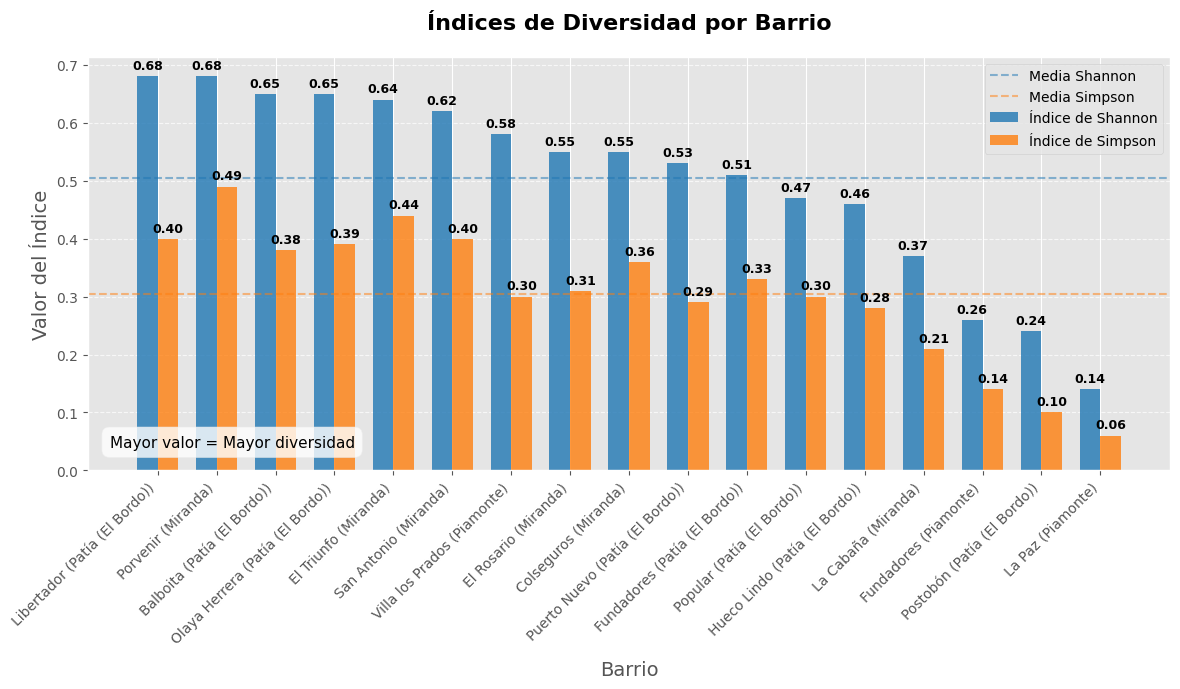

In [14]:
# Convertir los índices de string a float para la visualización
dff_plot = dff.copy()
dff_plot['Indice de Shannon'] = dff_plot['Indice de Shannon'].astype(float)
dff_plot['Indice de Simpson'] = dff_plot['Indice de Simpson'].astype(float)

# Ordenar por índice de Shannon para mejor visualización
dff_plot = dff_plot.sort_values('Indice de Shannon', ascending=False)

# Crear el gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(12, 7))

# Definir posiciones para las barras
x = np.arange(len(dff_plot['Localidad']))
width = 0.35

# Crear barras para cada índice
shannon_bars = ax.bar(x - width/2, dff_plot['Indice de Shannon'], width, label='Índice de Shannon', 
    color='#1f77b4', alpha=0.8)
simpson_bars = ax.bar(x + width/2, dff_plot['Indice de Simpson'], width, label='Índice de Simpson', 
    color='#ff7f0e', alpha=0.8)

# Añadir etiquetas, título y leyenda
ax.set_title('Índices de Diversidad por Barrio', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Barrio', fontsize=14, labelpad=10)
ax.set_ylabel('Valor del Índice', fontsize=14)
ax.set_xticks(x)

# Ajustar etiquetas de ejes para mejor legibilidad
ax.set_xticklabels(dff_plot['Localidad'], rotation=45, ha='right', fontsize=10)

# Añadir los valores sobre cada barra
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 puntos de desplazamiento vertical
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=9, fontweight='bold')

add_labels(shannon_bars)
add_labels(simpson_bars)

# Añadir una línea horizontal para facilitar comparación visual
ax.axhline(y=dff_plot['Indice de Shannon'].mean(), color='#1f77b4', linestyle='--', alpha=0.5, 
    label='Media Shannon')
ax.axhline(y=dff_plot['Indice de Simpson'].mean(), color='#ff7f0e', linestyle='--', alpha=0.5,
    label='Media Simpson')

# Añadir anotaciones explicativas
# Añadir una anotación explicativa en la esquina inferior derecha
ax.text(0.02, 0.05, 'Mayor valor = Mayor diversidad', transform=ax.transAxes, 
    fontsize=11, va='bottom', ha='left', 
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar diseño
plt.tight_layout()
plt.show()

### **Análisis de distribución geográfica detallada**

En esta sección, analizaremos la distribución geográfica de las especies encontradas, visualizando:

1. Mapa de calor de concentración de especímenes
2. Distribución de especies dominantes por región
3. Comparación de diversidad entre diferentes ubicaciones geográficas

In [ ]:
import folium
from folium.plugins import MarkerCluster, HeatMap

import matplotlib.colors as mcolors

# Create a base map centered on the mean coordinates of our data
center_lat = df['decimalLatitude'].mean()
center_lon = df['decimalLongitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10, 
               tiles='CartoDB positron')

# Create a colormap for the species
species_list = df['scientificName'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(species_list)))
species_colors = dict(zip(species_list, [mcolors.rgb2hex(c) for c in colors]))

# Add species distribution as markers with clusters
marker_cluster = MarkerCluster().add_to(m)

for idx, row in df.iterrows():
    species = row['scientificName']
    popup_text = f"""
    <b>Especie:</b> {species}<br>
    <b>Cantidad:</b> {row['individualCount']}<br>
    <b>Sexo:</b> {row['sex']}<br>
    <b>Localidad:</b> {row['locality'].split(' de ')[0].replace('Casa ubicada en el barrio ', '')}<br>
    <b>Fecha:</b> {row['eventDate']}
    """
    
    folium.CircleMarker(
        location=[row['decimalLatitude'], row['decimalLongitude']],
        radius=3 + (row['individualCount'] / 3),  # Size based on count
        popup=folium.Popup(popup_text, max_width=300),
        color=species_colors[species],
        fill=True,
        fill_color=species_colors[species],
        fill_opacity=0.7,
        weight=1
    ).add_to(marker_cluster)

# Add heatmap layer showing density of specimens
heat_data = [[row['decimalLatitude'], row['decimalLongitude'], row['individualCount']] 
             for _, row in df.iterrows()]

HeatMap(heat_data, 
        radius=15, 
        gradient={0.4: 'blue', 0.6: 'lime', 0.8: 'orange', 1.0: 'red'},
        blur=10,
        name='Densidad de especímenes',
        show=False
).add_to(m)

# Add a choropleth layer showing species richness by locality
locality_richness = df.groupby('locality')['scientificName'].nunique().reset_index()
locality_richness.columns = ['locality', 'species_richness']

# Add legend for species
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white;
            padding: 10px; border: 2px solid grey; border-radius: 5px">
<p><b>Especies:</b></p>
'''

for species, color in species_colors.items():
    legend_html += f'<p><i class="fa fa-circle" style="color:{color}"></i> {species}</p>'

legend_html += '''
<p><b>Tamaño del círculo:</b> Número de individuos</p>
</div>
'''

# Add layer control and legend
folium.LayerControl().add_to(m)
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

,decimalLatitude,decimalLongitude,individualCount,species_count
0,1.112500,-76.323770,1,1
1,1.112719,-76.323765,3,2
2,1.112867,-76.323877,4,1
3,1.112887,-76.323821,5,1
4,1.112921,-76.324925,3,1
...,...,...,...,...
429,3.260109,-76.228073,1,1
430,3.260136,-76.229231,1,1
431,3.260143,-76.232152,1,1
432,3.260237,-76.228626,1,1


In [20]:
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point, Polygon
import hvplot.pandas

# Define the place query
query = {'city': 'Patia'}

# Get the boundaries of the place
try:
    # Try the newer OSMnx API
    boundaries = ox.geocode_to_gdf(query)
    # Add buffer if needed using GeoDataFrame method
    boundaries['geometry'] = boundaries['geometry'].buffer(0.05)  # ~5km buffer in degrees
except TypeError:
    # Fallback method if buffer_dist isn't supported
    place = ox.geocode_to_gdf(query)
    # Create buffer manually
    boundaries = place.copy()
    boundaries['geometry'] = place['geometry'].buffer(0.05)  # ~5km buffer in degrees

# Let's check the boundaries on a map
ax = boundaries.explore(color='red', alpha=0.5)

boundaries.explore()

/tmp/ipykernel_22852/1366518926.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  boundaries['geometry'] = boundaries['geometry'].buffer(0.05)  # ~5km buffer in degrees


In [21]:


# Create point geometry from coordinates
df["geometry"] = gpd.points_from_xy(df["decimalLongitude"], df["decimalLatitude"])
df = gpd.GeoDataFrame(df, crs="epsg:4326")

# Plot the points on the same map
df.explore(m=ax, column='scientificName', categorical=True, 
           legend=True, marker_kwds={'radius': 5})

# Filter geographically - spatial join with boundaries
entomological_df = gpd.sjoin(df, boundaries[["geometry"]], predicate='within')
entomological_df = entomological_df.reset_index(drop=True)

# Alternative filtering by county name if spatial join doesn't work well
# entomological_df = df[df['county'] == 'Patía']

entomological_df.hvplot(geo=True, tiles="OSM", alpha=0.5, width=600, height=600, hover_cols=["name"])

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]